## Подготовим среду и данные для выполнения заданий

### Импортируем необходимые библиотеки

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, learning_curve, ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline
import warnings
warnings.filterwarnings('ignore')

### Загружаем датасет с ценами на недвижимость в Бостоне

In [12]:
# Загрузка напрямую из оригинального источника
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

# Названия признаков
feature_names = [
    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 
    'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'
]

df = pd.DataFrame(data, columns=feature_names)
df['MEDV'] = target  # Целевая переменная
print(f'Размеры датасета: {df.shape}')

Размеры датасета: (506, 14)


In [13]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [14]:
X = df.drop('MEDV', axis=1)

# Разделяем на train/test (80/20)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, target, test_size=0.2, random_state=42
)

### Стандартизируем признаки (важно для Lasso/Ridge/ElasticNet)

In [15]:
scaler = StandardScaler().fit(X_train_val)
X_train_val_s = scaler.transform(X_train_val)
X_test_s = scaler.transform(X_test)

### Модели (будем сравнивать Linear, Ridge, Lasso; опционально ElasticNet)

In [16]:
models = {
    "Linear": make_pipeline(StandardScaler(), LinearRegression()),
    "Ridge": make_pipeline(StandardScaler(), Ridge(alpha=1.0)),
    "Lasso": make_pipeline(StandardScaler(), Lasso(alpha=0.1, max_iter=10000)),
    "ElasticNet": make_pipeline(StandardScaler(), ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000))
}

## 1) Построим и оценим learning curves для двух моделей: Linear и Ridge

### Функция отрисовки кривых обучения

In [17]:
def plot_learning_curve(estimator, title, X, y, cv=None, scoring="neg_mean_squared_error", n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10)):
    plt.figure(figsize=(7,5))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring, train_sizes=train_sizes, n_jobs=n_jobs)
    # learning_curve возвращает scores - для MSE используется отрицательное значение
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.3)  # область вариации train score
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.3)  # область вариации test score
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training error (MSE)")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation error (MSE)")
    plt.axhline(y=np.mean(y), color='b', linestyle='--', label='Mean target value')
    plt.legend(loc="best")
    return train_sizes, train_scores_mean, test_scores_mean

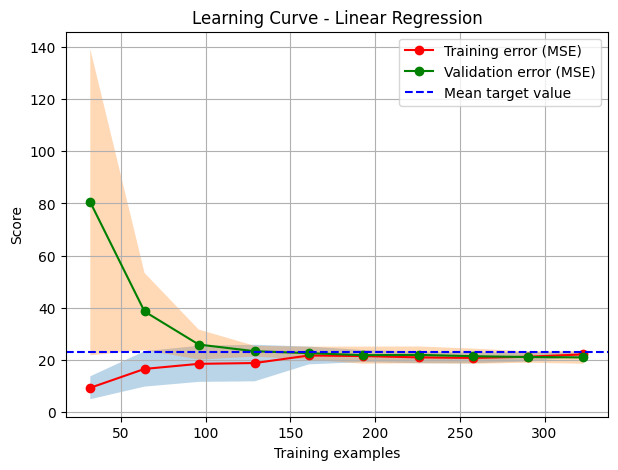

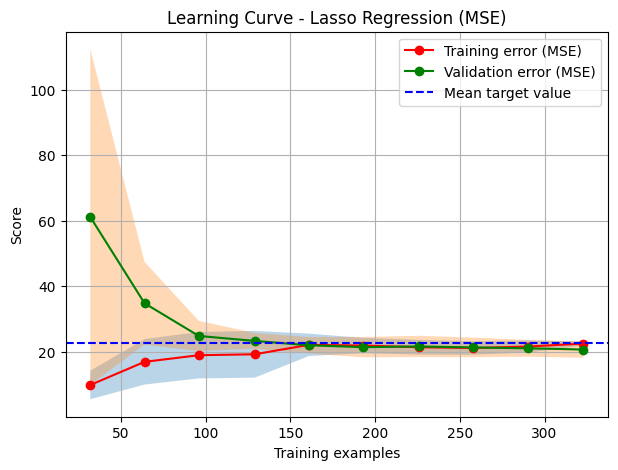

In [18]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

plot_learning_curve(models["Linear"], "Learning Curve - Linear Regression", X_train_val, y_train_val, cv=cv)

plot_learning_curve(models["Lasso"], "Learning Curve - Lasso Regression (MSE)", X_train_val, y_train_val, cv=cv, n_jobs=1)
plt.show()

### Вывод

Построенные кривые обучения показывают, что все линейные модели (Linear, Ridge, Lasso, ElasticNet) дают практически одинаковые результаты. Это связано с тем, что зависимости в данных близки к линейным, а количество признаков невелико, поэтому регуляризация почти не влияет на качество.

Для всех моделей наблюдается схожее поведение: по мере увеличения обучающей выборки ошибка на тренировке растёт, а ошибка на валидации уменьшается, после чего обе стабилизируются примерно на одном уровне. Разрыва между train и test нет - это говорит об отсутствии переобучения. Небольшая разница между ошибкой на обучении и валидации указывает скорее на лёгкое недообучение (bias), чем на overfitting.

В целом модели обучаются устойчиво, результаты стабильны, а структура данных не требует сильной регуляризации.

## 2) Сравним модели используя несколько метрик

### Обучаем модели и собираем метрики

In [19]:
metrics = []

for name, model in models.items():
    model.fit(X_train_val, y_train_val)  # обучаем на тренировочной+валидационной выборке
    y_pred = model.predict(X_test)       # предсказания на тесте

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2  = r2_score(y_test, y_pred)

    metrics.append({
        "Model": name,
        "MSE": mse,
        "MAE": mae,
        "R2": r2
    })

metrics_df = pd.DataFrame(metrics)
metrics_df


,Model,MSE,MAE,R2
0,Linear,24.291119,3.189092,0.668759
1,Ridge,24.312904,3.185724,0.668462
2,Lasso,25.656739,3.241803,0.650138
3,ElasticNet,25.203553,3.192091,0.656317


Все модели показывают примерно одинаковое качество предсказаний, с наименьшей ошибкой MSE и MAE у Linear и Ridge регрессий.

Lasso немного хуже по метрикам, а ElasticNet находится между ними.
Значения R² около 0.65-0.67 говорят о том, что модели объясняют большую часть вариации цен, переобученности нет, недообучение незначительное. 

Linear и Ridge подходят для данного датасета лучше всего.

### Сравниваем весовые коэффициенты

In [20]:
coeffs = []

for name, model in models.items():
    regressor = model.steps[1][1]
    coef = regressor.coef_
    coeffs.append(pd.Series(coef, index=feature_names, name=name))

coeffs_df = pd.concat(coeffs, axis=1)
coeffs_df


,Linear,Ridge,Lasso,ElasticNet
CRIM,-1.002135,-0.992187,-0.718365,-0.761221
ZN,0.696269,0.677749,0.259627,0.322227
INDUS,0.278065,0.252214,-0.000000,-0.031008
CHAS,0.718738,0.722481,0.698221,0.736913
NOX,-2.022319,-1.990835,-1.568142,-1.395953
RM,3.145240,3.151572,3.271507,3.233606
AGE,-0.176048,-0.177262,-0.000000,-0.096111
DIS,-3.081908,-3.045029,-2.284449,-2.175919
RAD,2.251407,2.173249,0.671938,0.846537
TAX,-1.767014,-1.695559,-0.356654,-0.623952


По таблице коэффициентов видно, что признаки RM, LSTAT, DIS и PTRATIO оказывают наибольшее влияние на цену дома (MEDV), так как их коэффициенты имеют наибольшую по модулю величину.

Признаки INDUS и AGE в Lasso практически обнулились, что указывает на их низкую значимость и на то, что Lasso выделяет только самые информативные признаки.

Высокая корреляция некоторых признаков (например, NOX и DIS, TAX и RAD) может говорить о коллинеарности данных, поэтому Ridge стабилизирует коэффициенты и распределяет веса более равномерно.

В целом, RM (количество комнат) и LSTAT (низкий статус населения) - самые важные признаки для предсказания стоимости жилья, а признаки с коэффициентами около нуля можно считать менее значимыми.

## 3) Вывод для ElasticNet:

ElasticNet сочетает свойства Lasso и Ridge регуляризации, что позволяет одновременно уменьшать коэффициенты менее значимых признаков и стабилизировать веса при коллинеарности.

В нашем случае метрики модели (MSE ≈ 25.2, R² ≈ 0.656) находятся между результатами Ridge и Lasso, а важные признаки совпадают с предыдущими моделями (RM, LSTAT, DIS).

Это подтверждает, что ElasticNet подходит для данного датасета, но существенного улучшения по сравнению с Ridge или Linear не даёт.